# Reparameterize force fields

The `MMForceFieldGenerator` class in `VeloxChem` provides a number of functions to manipulate topology files. As an example, we consider the optimization of the force field parameters for a dihedral angle of a thiophene-based optical ligand named HS-276.

Load the required modules and the equilibrium geometry:

In [1]:
import veloxchem as vlx
import numpy as np

# load B3LYP optimized geometry in the xyz format
molecule = vlx.Molecule.read_xyz_file("../../data/md/hs276.xyz")
molecule.show(atom_indices=True, width=600, height=450)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We here consider the dihedral angle between the two thiophene rings, which corresponds to the rotation around bond 21-22.

The dihedral potential curves will be plotted using force field parameters from the general amber forcefield (GAFF) database, as compared to QM results. The force field will then be changed to better fit this potential.

## Create the initial force field

Initialize an `MMForceFieldGenerator` object and generate initial force field with pre-calculated [RESP charges](../env/resp):

In [2]:
resp_chg = np.array([
    0.014967, 0.224409, 0.089489, -0.551618, 0.153050, 0.106847, -0.315042,
    0.165854, 0.206441, -0.425163, 0.225816, -0.039099, 0.179377, 0.002119,
    0.014483, -0.043666, -0.230202, 0.165960, -0.071404, 0.188598, -0.044661,
    0.088786, -0.173586, 0.175730, -0.089376, 0.164515, -0.118573, -0.150541,
    0.736497, -0.570770, -0.273724, -0.144051, 0.112846, 0.112846, 0.112846
])

ff_gen = vlx.MMForceFieldGenerator()
ff_gen.partial_charges = resp_chg
ff_gen.create_topology(molecule)

* Info * Using GAFF (v2.11) parameters.                                                                                   
         Reference: J. Wang, R. M. Wolf, J. W. Caldwell, P. A. Kollman, D. A. Case, J. Comput. Chem. 2004,
         25, 1157-1174.
                                                                                                                          
* Info * Updated bond angle 1-9-10 (ca-ca-cc) to 107.217 deg                                                              
* Info * Updated bond angle 1-14-15 (ca-na-cc) to 126.641 deg                                                             
* Info * Updated bond angle 2-1-14 (ca-ca-na) to 131.687 deg                                                              
* Info * Updated bond angle 7-9-10 (ca-ca-cc) to 135.297 deg                                                              
* Info * Updated bond angle 9-1-14 (ca-ca-na) to 107.608 deg                                                              
* Info *

## Reparametrize the force field

Use the `reparametrize_dihedrals` method to fit dihedral parameters to QM scan:

                                           VeloxChem Dihedral Reparametrization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
* Info * Reading QM scan from file...                                                                                     
* Info *   ../../data/md/27-22-21-16.xyz                                                                                  
                                                                                                                          
* Info * Dihedral barriers [4.184 4.184 4.184 4.184] will be used as initial guess.                                       
* Info * Validat

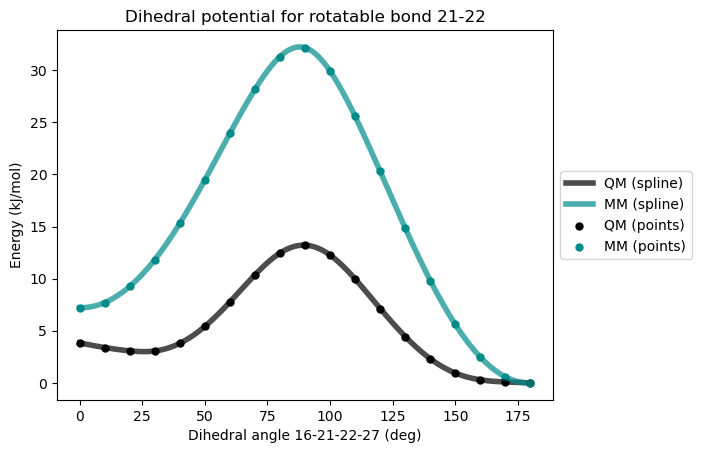

* Info * Performing dihedral scan for MM baseline...                                                                      
                                                                                                                          
* Info *   Target dihedral angle: 16-21-22-27                                                                             
                                                                                                                          
* Info *       Dihedral           MM energy                                                                               
* Info *   --------------------------------                                                                               
* Info *        0.0 deg       38.292 kJ/mol                                                                               
* Info *       10.0 deg       37.834 kJ/mol                                                                               
* Info *       2

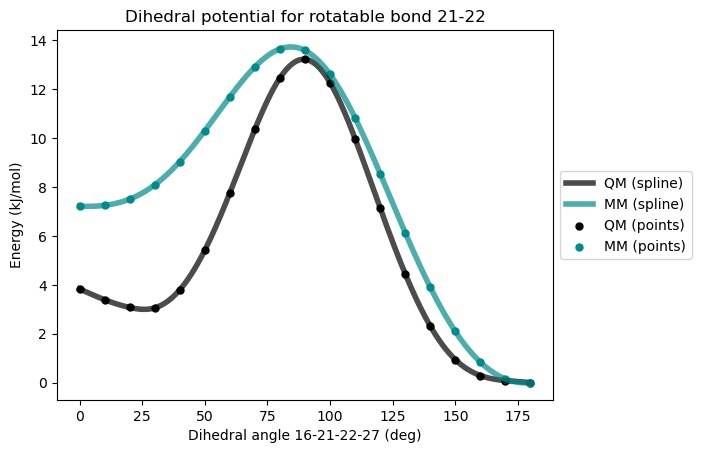

* Info * Dihedral MM parameters have been reparametrized and updated in the topology.                                     


In [3]:
ff_gen.reparametrize_dihedrals(rotatable_bond=(21,22), scan_file="../../data/md/27-22-21-16.xyz", visualize=True)

It is not uncommon that the existing dihedral terms in the force field are not sufficient to reproduce the QM potential. Here we can try adding more dihedral terms to the force field, and then redo the fitting. We can also skip the initial validation step by setting `initial_validation` to `False`.

In [4]:
ff_gen.add_dihedral((16, 21, 22, 27), barrier=0.0, phase=180.0, periodicity=1)
ff_gen.add_dihedral((16, 21, 22, 27), barrier=0.0, phase=0.0, periodicity=4)

* Info * Added dihedral 16-21-22-27                                                                                       
* Info * Added dihedral 16-21-22-27                                                                                       


                                           VeloxChem Dihedral Reparametrization                                           
                                                                                                                          
* Info * Rotatable bond selected: 21-22                                                                                   
* Info * Dihedrals involved:[[16, 21, 22, 23], [16, 21, 22, 27], [19, 21, 22, 23], [19, 21, 22, 27]]                      
* Info * Reading QM scan from file...                                                                                     
* Info *   ../../data/md/27-22-21-16.xyz                                                                                  
                                                                                                                          
* Info * Dihedral barriers [1.85974499 1.85974499 0.         0.         1.85974499 1.85974499] will be used as initial guess.
* Info * Perf

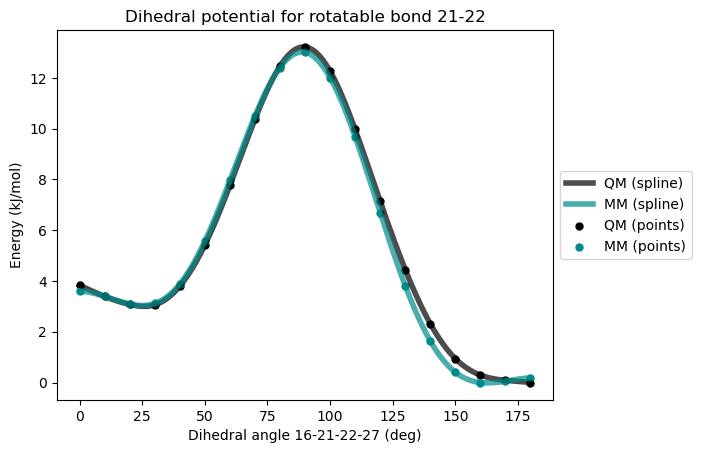

* Info * Dihedral MM parameters have been reparametrized and updated in the topology.                                     


In [5]:
ff_gen.reparametrize_dihedrals(rotatable_bond=(21,22), scan_file="../../data/md/27-22-21-16.xyz", visualize=True, initial_validation=False)

## Save the force field to file

Use `write_gromacs_files` or `write_openmm_files` to write the force field to files.

In [6]:
ff_gen.write_gromacs_files('hs276')